<a href="https://colab.research.google.com/github/stmulugheta/AI/blob/main/DAGsHub_Stack_Exchange_Tutorial_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center> <img alt="DAGsHub" width=500px src=https://raw.githubusercontent.com/DAGsHub/client/master/dagshub_github.png> </center>

# Stack Exchange Tutorial - Exploratory Data Analysis (EDA)
This notebook is the analysis of the data used in [DAGsHub's tutorial](https://dagshub.com/docs/experiment-tutorial/overview/).

It's here mostly to give more in-depth explanations and code for those who are interested, and allows you to easily modify the code and try different things.

If you just want to learn how to use DAGsHub, we suggest you just read through the [tutorial](https://dagshub.com/docs/experiment-tutorial/overview/), where we [explain the important parts of the results of this EDA](https://dagshub.com/docs/tutorial/0-data), as well as:

* [How to experiment with different models, data preprocessing and feature engineering](https://dagshub.com/docs/experiment-tutorial/2-experiments/)
* How to keep versions of your data and models, so that all of your experiments are automatically reproducible - TBD – for now go to our [Data Versioning Tutorial to learn this](https://dagshub.com/docs/tutorial/overview/)

In [1]:
# IMPORTANT! Restart the runtine after running this cell once
!pip install --upgrade pandas-profiling==2.9.0

     |████████████████████████████████| 258 kB 27.4 MB/s 
     |████████████████████████████████| 675 kB 37.9 MB/s 
     |████████████████████████████████| 4.7 MB 39.2 MB/s 
     |████████████████████████████████| 64 kB 4.0 MB/s 
     |████████████████████████████████| 812 kB 43.0 MB/s 
     |████████████████████████████████| 28.5 MB 49 kB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=1b56d96d82fb83da88e27f1f5c9abf16be0b73a2368e43cae094513eb526223e
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=364a461a0292c0bda227462f4f1211aad43c2187f9dbc00a7f4040dc01d78c3e
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
Successfully built htmlmin imagehash
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstallin

## Download raw data
The source of the data is the Cross Validated Stack Exchange API. 
It's a table of Questions.
 
You can find the original query, play with it, get updated data, etc. here: https://data.stackexchange.com/stats/query/1290704/relevant-crossvalidated-posts-latest

For your convenience and in order for you to get consistent results with the tutorial, we've stored this data on our publically
readable cloud storage.

In [2]:
!wget https://dagshub-public.s3.us-east-2.amazonaws.com/tutorials/stackexchange/CrossValidated-Questions-Nov-2020.csv -O CrossValidated-Questions.csv

--2021-10-17 06:24:53--  https://dagshub-public.s3.us-east-2.amazonaws.com/tutorials/stackexchange/CrossValidated-Questions-Nov-2020.csv
Resolving dagshub-public.s3.us-east-2.amazonaws.com (dagshub-public.s3.us-east-2.amazonaws.com)... 52.219.101.194
Connecting to dagshub-public.s3.us-east-2.amazonaws.com (dagshub-public.s3.us-east-2.amazonaws.com)|52.219.101.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75856988 (72M) [text/csv]
Saving to: ‘CrossValidated-Questions.csv’

CrossValidated-Ques 100%[===================>]  72.34M  76.7MB/s    in 0.9s    

2021-10-17 06:24:55 (76.7 MB/s) - ‘CrossValidated-Questions.csv’ saved [75856988/75856988]



In [3]:
!ls -lah

total 73M
drwxr-xr-x 1 root root 4.0K Oct 17 06:24 .
drwxr-xr-x 1 root root 4.0K Oct 17 06:22 ..
drwxr-xr-x 4 root root 4.0K Oct  8 13:44 .config
-rw-r--r-- 1 root root  73M Nov 10  2020 CrossValidated-Questions.csv
drwxr-xr-x 1 root root 4.0K Oct  8 13:45 sample_data


## Load data for processing
Since this is a CSV file, we can load it using [Pandas](https://pandas.pydata.org/) for processing.

In [4]:
import pandas as pd
df = pd.read_csv('CrossValidated-Questions.csv')
df

Id  ... FavoriteCount
0      495508  ...           NaN
1      495507  ...           NaN
2      495506  ...           NaN
3      495503  ...           NaN
4      495502  ...           1.0
...       ...  ...           ...
49995  371394  ...           NaN
49996  371389  ...           1.0
49997  371388  ...           NaN
49998  371386  ...           NaN
49999  371383  ...           NaN

[50000 rows x 10 columns]

The columns are pretty self explanatory - we have:

* Two textual features (`Title` & `Body`). 

  We can already tell that this text is actually full of HTML tags, which we will probably need to clean to get good results.
  
* One string column that is actually the list of `Tags` for this question. This contains the target `machine-learning` tag we want to predict.
* Some numeric features: `Score, ViewCount, AnswerCount, CommentCount, FavoriteCount`
* One `CreationDate` feature that needs to be processed correctly:

In [5]:
df['CreationDate'] = pd.to_datetime(df['CreationDate'])
# Also include the numeric representation of the timestamp, so we can look at its distribution / correlation with other features
df['CreationDate_Epoch'] = df['CreationDate'].astype('int64') // 10 ** 9

Also, remember that our end goal here is to **classify questions about Machine Learning**.
This information is stored in the `Tags` column:

In [6]:
df['MachineLearning'] = df['Tags'].str.contains('machine-learning').fillna(False)

Now we can drop the non-informative columns

In [7]:
df = df.drop(columns=['Id','Tags'])

Some positive and negative samples:

In [8]:
df[df['MachineLearning']].sample(5)

Title  ... MachineLearning
7803   How to present ML model performance before dep...  ...            True
15166                            Softmax backpropagation  ...            True
21144  Introduction to Statistical Learning with R Eq...  ...            True
8714   proof of For $G$ fixed, the optimal discrimina...  ...            True
44035  How to simulate discrete data from a Poisson d...  ...            True

[5 rows x 10 columns]

In [9]:
df[df['MachineLearning'] != True].sample(5)

Title  ... MachineLearning
24332  Machine Translation: with sufficient parallel ...  ...           False
45035  ROC and PR curves after over/under sampling in...  ...           False
23825  Interpret Interaction Effects in Negative Bino...  ...           False
30320  When is performing back-transformation of infe...  ...           False
23339  How to transform the covariance matrix for a G...  ...           False

[5 rows x 10 columns]

We can define a new `Title_Len` and `Body_Len` column to get interesting statistics on question length

In [10]:
df['Title_Len'] = df.Title.str.len()
df['Body_Len'] = df.Body.str.len()

## Data Exploration
Now, let's try to get a sense of the data distribution. We start out with a simple pandas describe on all columns.

In [11]:
df.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


Title  ...     Body_Len
count                                               50000  ...  50000.00000
unique                                              49972  ...          NaN
top     Interpreting nested mixed effects modelling ou...  ...          NaN
freq                                                    2  ...          NaN
first                                                 NaN  ...          NaN
last                                                  NaN  ...          NaN
mean                                                  NaN  ...   1336.45880
std                                                   NaN  ...   1439.36074
min                                                   NaN  ...     38.00000
25%                                                   NaN  ...    590.00000
50%                                                   NaN  ...    975.00000
75%                                                   NaN  ...   1623.00000
max                                                   NaN  ...  29616.00000

[13 rows x 12 columns]

Also, it's good to know that we don't need to deal with null values in this dataset. It seems safe to assume that the 82% of rows with `FavoriteCount == null` can be imputed to zeroes, meaning no user marked these questions as favorite.

In [12]:
df.isnull().sum() * 100 / df.shape[0]

Title                  0.000
Body                   0.000
CreationDate           0.000
Score                  0.000
ViewCount              0.000
AnswerCount            0.000
CommentCount           0.000
FavoriteCount         82.164
CreationDate_Epoch     0.000
MachineLearning        0.000
Title_Len              0.000
Body_Len               0.000
dtype: float64

We'll use [Seaborn](https://seaborn.pydata.org/) to visualize data. It should be automatically available in the Google Colab environment.

In [13]:
import seaborn as sns
sns.set()

Looks like about 11.1% of the data is labeled as `machine-learning`. 
This means this will be an unbalanced classification problem, but not catastrophically unbalanced.

11.104% labeled True


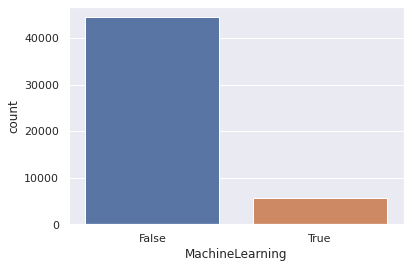

In [14]:
sns.countplot(x='MachineLearning', data=df, )
print(f"{df['MachineLearning'].mean() * 100}% labeled True")

To quickly get a feel for the distribution of data, we can use [`pandas-profiling`](https://github.com/pandas-profiling/pandas-profiling).

Note that the output is long and scrollable, so be sure to scroll through.

Some quick observations from this report are:
* We should drop the `FavoriteCount` column, since it's highly correlated with `Score`
* `Score, ViewCount, AnswerCount` are highly skewed, so we might take that into account in data preparation.
* Our label `MachineLearning` is not too strongly related with any other single feature
* The `CreationDate` field is negatively correlated with most numeric fields, which would make sense as newer questions haven't had as much time to gather views, upvotes and answers.
* `Body_Len` is negatively correlated with `AnswerCount`, which also makes sense - people are probably less inclined to read through a long question before answering it

There are probably many other things to learn from this report, but we'll leave it for now. [In the next part of the tutorial](https://dagshub.com/docs/tutorial/1-experiments), we'll use what we've learned about the data to process it for training models.

In [15]:
from pandas_profiling import ProfileReport
ProfileReport(df)

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# Drop the correlated features
df = df.drop(columns=['FavoriteCount'])

## Processing the data

First things first - we should split the data into train and test sets.

Even before training the model itself, the preprocessing stages are supposed to fit only the training data, not the test data.

In [17]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df)

Here, we try to scale and transform the numeric features to make them smoother, less skewed, and more appropriate for modeling.

`PowerTransformer` attempts to make the data more like a normal distribution, which should soften the impact of extreme outliers and make the distributions smoother.

`MinMaxScaler` is used as a first step to make sure the numbers are in a reasonable range, as `PowerTransformer` can fail on very large numbers.

In [18]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(MinMaxScaler(), PowerTransformer())
numeric_col_names = ['Title_Len','Body_Len','CreationDate_Epoch','AnswerCount','ViewCount','Score','CommentCount']
train_df_norm = pd.DataFrame(pipeline.fit_transform(train_df[numeric_col_names]), columns=numeric_col_names)
train_df_norm = train_df_norm.combine_first(train_df.reset_index()) # Add the other columns back

In [19]:
test_df_norm = pd.DataFrame(pipeline.transform(test_df[numeric_col_names]), columns=numeric_col_names)
test_df_norm = test_df_norm.combine_first(test_df.reset_index()) # Add the other columns back

Looking at the new distribution of the features, we can see they're now scaled correctly and not as skewed.

In [ ]:
sns.pairplot(train_df_norm.drop(columns=['index','CreationDate']), hue='MachineLearning')

## Model training

Now, we'll fit a basic Logistic Regression model to our data, to see that it manages to learn anything. We're not trying to optimize it yet, just see that it successfully learns something useful, and that our preparation of the data helped.

For the time being, we'll only use the *numeric* columns for this model. The textual columns require specialized preprocessing before they can be used as input to a model.

We'll drop the `CreationDate` column, as its information is already stored in the scaled `CreationDate_Epoch` column.

To get a good idea of how well the model learned something useful about the data, we also reserve some of the data for testing.

In [ ]:
import sklearn.linear_model
clf = sklearn.linear_model.LogisticRegression()
train_cols = [c for c in numeric_col_names if c != 'CreationDate']
X = train_df_norm[train_cols]
y = train_df_norm['MachineLearning']
clf.fit(X, y)

## Evaluation

Since we know that the classes are very imbalanced (only about 8% of the questions labeled as `machine-learning`), we'll avoid using the accuracy metric as an indication. Instead, we'll take a look at the precision-recall curve and ROC, which can tell us more useful information.

In [ ]:
import sklearn.metrics
X_test = test_df_norm[train_cols]
y_test = test_df_norm['MachineLearning']
sklearn.metrics.plot_precision_recall_curve(clf, X_test, y_test)
sklearn.metrics.plot_roc_curve(clf, X_test, y_test)

We can also look at the learned feature importances to understand what our model is looking for:

In [ ]:
sns.barplot(y=train_cols, x=clf.coef_[0])

Looking at the following curves, we can see that the model really did learn useful information from the data, better than random at least. 

Let's compare to a classifier trained on the unscaled data:

In [ ]:
clf_raw = sklearn.linear_model.LogisticRegression()
X_raw = train_df[train_cols]
y_raw = train_df['MachineLearning']
clf_raw.fit(X_raw, y_raw)

X_test_raw = test_df[train_cols]
y_test_raw = test_df['MachineLearning']
sklearn.metrics.plot_precision_recall_curve(clf_raw, X_test_raw, y_test_raw)
sklearn.metrics.plot_roc_curve(clf_raw, X_test_raw, y_test_raw)

Clearly our data preprocessing helped - using the raw data yielded results that are even worse than random!

For sanity checking, let's compare it to a naive model, which always just guesses the common label:

In [ ]:
import sklearn.dummy
clf_dummy = sklearn.dummy.DummyClassifier()
clf_dummy.fit(X, y)

sklearn.metrics.plot_precision_recall_curve(clf_dummy, X_test, y_test)
sklearn.metrics.plot_roc_curve(clf_dummy, X_test, y_test)

## Textual Features

So, at this point we have a sense for our data, have found a good way to scale and normalze our *numeric* features, and have trained a very basic classifier on it.

The next phase would be to see what happens when we take advantage of our textual features - `Title` & `Body`. We'll use *only* the textual features to simplify things and isolate the effects.

To make things simple, we'll unify them into one big textual column.

In [ ]:
train_text_col = train_df_norm['Title'].fillna('') + ' ' + train_df_norm['Body'].fillna('')
test_text_col = test_df_norm['Title'].fillna('') + ' ' + test_df_norm['Body'].fillna('')

To turn this text into numerical features that can be used as input to a ML model, we'll use [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) with a sensible limit of vocabulary size (`max_features=25000`). It will split the text into tokens, and give each question in the data a numerical representation of the frequency of tokens in that question.

Note that special care is needed when handling [sparse matrices in Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html), and the result returned from `TfidfVectorizer` is a sparse matrix. **If you ignore this special handling, expect to run into out-of-memory errors, unresponsiveness and crashes as the sparse matrix gets inflated.**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=25000)
tfidf.fit(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_text_col), columns=tfidf.get_feature_names())
test_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(test_text_col), columns=tfidf.get_feature_names())

**Interesting notes:** Looks like many of the learned terms are: 
* Various numbers, like `00`, `00000000e` etc. It could be useful to prevent this splitting of numbers into many different terms in the vocabulary, since it probably won't matter to classifying the text.
* Multiple terms grouped together due to an underscore, like `variable_2`. This is probably an artifact of embedded Python or TeX code. It might help the model if we break these down to separate terms.
* Remember, the questions contain embedded HTML. While we're not seeing any terms that were clearly garbage created by HTML, it's a good bet that it will be useful to clean up the HTML tags in the text.

In [ ]:
train_tfidf_df.sample(15, axis=1)

In [ ]:
clf_tfidf = sklearn.linear_model.LogisticRegression()
clf_tfidf.fit(train_tfidf_df.sparse.to_coo(), y)

## Evaluating the textual model
Below, we can see that the new text-based model performs stunningly well!

This is not surprising, as most information will be contained in the text content of each question.

In [ ]:
X_tfidf_test = test_tfidf_df.sparse.to_coo()
sklearn.metrics.plot_precision_recall_curve(clf_tfidf, X_tfidf_test, y_test)
sklearn.metrics.plot_roc_curve(clf_tfidf, X_tfidf_test, y_test)

As a sanity check, it's a good idea to check what terms the textual model cares about when making its decision.

As we see below, it looks like our model learned some very good, sensible terms, that we would have probably guessed on our own, such as `machine`, `learning`, `classifier`, etc.

It's interesting to note that `analysis` is a *negative*  predictor for a question about machine learning, as opposed to a general statistical question. Just throw a neural network at it 😅

In [ ]:
tfidf_coef_df = pd.DataFrame({'coef':clf_tfidf.coef_[0]})
tfidf_coef_df['term'] = tfidf.get_feature_names()
tfidf_coef_df['coef_abs'] = tfidf_coef_df['coef'].abs()
tfidf_coef_df = tfidf_coef_df.sort_values('coef_abs', ascending=False)
sns.barplot(y='term', x='coef', data=tfidf_coef_df[:20])

[![Stack More Layers](https://stackmorelayers.be/bg.png)](https://stackmorelayers.be)

# Conclusion

We got a good sense of our data, the type of preprocessing required, and managed to train some decent classifiers with it.

At this point in a Python data science project, it's common to take the conclusions and working code from the exploratory notebook, and turn them into normal Python modules. This enables us to more easily:
* Create reusable components that will be useful as the project matures.
* Use code versioning tools like Git.
* Make the process more reproducible by defining a clear pipeline (order of operations) for the data and model training.
* Automate running and tracking of experiments.
* Version our different experiments and models, so that we preserve knowledge and don't risk losing work by accident.

[In the next level of DAGsHub's tutorial](https://dagshub.com/docs/experiment-tutorial/1-setup/), we'll take what works from this notebook and turn it into a Python project, before [going forward with experimentation](https://dagshub.com/docs/experiment-tutorial/2-experiments/) to find the best performing model for out problem.

Made with 🐶 by [DAGsHub](https://dagshub.com).